# Hyper-parameter optimization with skorch and optuna

Hyper-parameter optimization with skorch works right out of the gate in conjunction with sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), as documented e.g. [here](https://skorch.readthedocs.io/en/stable/user/quickstart.html#grid-search). However, these are not the most efficient hyper-parameter optimization algorithms. Here we show how easy it is to use optuna for hyper-parameter optimization in conjunction with skorch.

Optuna provides a few advantages over sklearn's offerings. Most notably, it can [prune](https://optuna.readthedocs.io/en/stable/tutorial/007_pruning.html) unpromising fits instead of having to wait until the final epoch has been reached. This way, we don't lose much time running bad hyper-parameter combinations.

Find out about this and more of optuna's advantages [here](https://optuna.readthedocs.io/).

**Note**: To run this notebook, you need to install optuna first: `pip install -U optuna >= 2.3.0`

This notebook shows some more advanced features of `skorch`. More examples will be added with time.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/optuna-example.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/optuna-example.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch optuna matplotlib

## imports

In [2]:
import os

import numpy as np
import optuna
from optuna.integration import SkorchPruningCallback
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback
import torch
import torch.nn as nn
import torch.optim as optim

## constants

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
METRIC_NAME = 'valid_acc'
DIRECTION = 'maximize'  # we want to optimize accuracy, hence higher values are better
SAMPLER = optuna.samplers.TPESampler(seed=0)

## custom functions

In [5]:
def get_data():
    X, y = make_classification(1000, n_informative=15, random_state=0)
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    return X, y

In [6]:
class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=nn.ReLU(), dropout_rate=0.5):
        super(MyModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout_rate = dropout_rate
        
        self.reset_weights()
        
    def reset_weights(self):
        self.dense0 = nn.Linear(20, self.num_units)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.dense1 = nn.Linear(self.num_units, self.num_units)
        self.output = nn.Linear(self.num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X

In [7]:
def define_model(trial):
    """Model definition and hyper-parameter setting

    We set the number of units, the optimizer, the learning rate, and the number of epochs.
    
    To make this work efficiently with optuna, add the
    `SkorchPruningCallback <https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html?highlight=optuna.integration.OptunaSearchCV>`
    from the optuna library.

    """
    num_units = trial.suggest_int('num_units', 10, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    optimizer = getattr(optim, optimizer_name)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    max_epochs = trial.suggest_int('max_epochs', 5, 25)
    
    return NeuralNetClassifier(
        MyModule,
        module__num_units=num_units,
        optimizer=optimizer,
        lr=lr,
        max_epochs=max_epochs,
        verbose=0,
        device=DEVICE,
        callbacks=[SkorchPruningCallback(trial, monitor='valid_acc')],
    )

In [8]:
def objective(trial):
    """Train the model and return the value to be maximized"""
    model = define_model(trial)
    X, y = get_data()
    model.fit(X, y)
    accuracy = model.history[-1, METRIC_NAME]
    return accuracy

## run optuna trials

In [9]:
%%time
study = optuna.create_study(direction=DIRECTION, sampler=SAMPLER)  # maximize accuracy
study.optimize(objective, n_trials=50, timeout=600)

[I 2020-11-22 16:03:12,722] A new study created in memory with name: no-name-1c37217c-f1de-4d09-82f2-b1e88c6924f3
[I 2020-11-22 16:03:12,971] Trial 0 finished with value: 0.84 and parameters: {'num_units': 10, 'optimizer': 'Adam', 'lr': 0.027026043440193118, 'max_epochs': 12}. Best is trial 0 with value: 0.84.
[I 2020-11-22 16:03:13,106] Trial 1 finished with value: 0.815 and parameters: {'num_units': 19, 'optimizer': 'Adam', 'lr': 0.0038333321561566623, 'max_epochs': 9}. Best is trial 0 with value: 0.84.
[I 2020-11-22 16:03:13,375] Trial 2 finished with value: 0.585 and parameters: {'num_units': 33, 'optimizer': 'SGD', 'lr': 1.685978023170582e-05, 'max_epochs': 17}. Best is trial 0 with value: 0.84.
[I 2020-11-22 16:03:13,724] Trial 3 finished with value: 0.66 and parameters: {'num_units': 11, 'optimizer': 'SGD', 'lr': 0.01772861933751491, 'max_epochs': 19}. Best is trial 0 with value: 0.84.
[I 2020-11-22 16:03:14,069] Trial 4 finished with value: 0.895 and parameters: {'num_units': 3

CPU times: user 25.3 s, sys: 363 ms, total: 25.7 s
Wall time: 6.43 s


## report results

In [10]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  29
  Number of complete trials:  21


In [11]:
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

Best trial:
  Value:  0.935


In [12]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    num_units: 31
    optimizer: Adam
    lr: 0.019476300983188265
    max_epochs: 13


## visualize

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: is_available is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.
/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  
/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  after removing the cwd from sys.path.


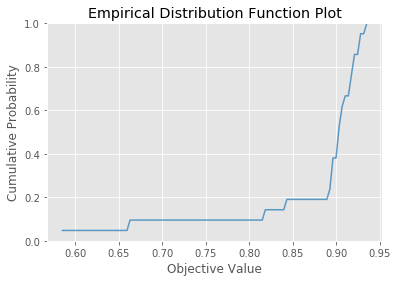

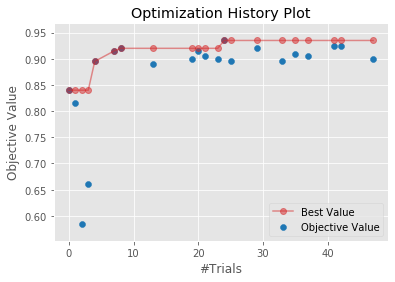

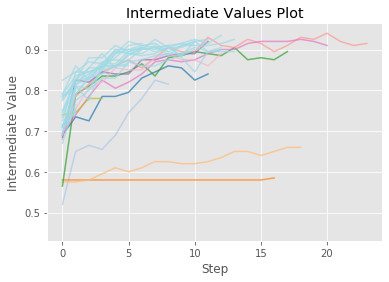

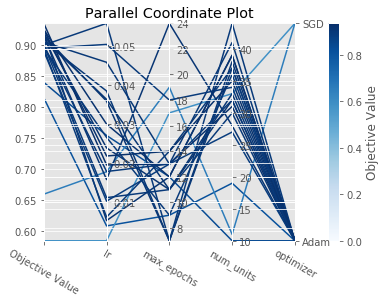

In [14]:
if optuna.visualization.matplotlib.is_available():
    optuna.visualization.matplotlib.plot_edf(study)
    optuna.visualization.matplotlib.plot_optimization_history(study)
    optuna.visualization.matplotlib.plot_intermediate_values(study)
    optuna.visualization.matplotlib.plot_parallel_coordinate(
        study, params=['num_units', 'lr', 'max_epochs', 'optimizer'])